In [23]:
import datetime
import duckdb
import numpy as np
import pandas as pd
import seaborn
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

In [42]:
dataset = 'sp500_2023.db'

# which stock to predict
target = 'DIS'

# load the training data
with duckdb.connect(dataset, read_only=True) as con:
    df = con.sql("SELECT * FROM stocks").df()

# calculate the percent change for the day
df['pct'] = (df.close - df.open) / df.open
    
# load the batch normalization
norm = pd.read_csv('batch_norm.csv', sep='\t', header=0)

# only keep stocks that have been normalized
df = df[df.stock.isin(norm.stock)]
df

,stock,date,open,high,low,close,volume,trade_count,vwap,pct
0,AAL,2023-01-03,12.91,13.0000,12.5250,12.74,23085284.0,76244.0,12.715926,-0.013168
1,AAL,2023-01-04,12.86,13.6100,12.8600,13.59,36733223.0,105522.0,13.409713,0.056765
2,AAL,2023-01-05,13.50,14.0100,13.4200,13.99,28806544.0,93272.0,13.860432,0.036296
3,AAL,2023-01-06,14.01,14.2500,13.9150,14.18,31383251.0,92630.0,14.129296,0.012134
4,AAL,2023-01-09,14.25,14.7900,14.2300,14.61,33123654.0,105294.0,14.637295,0.025263
...,...,...,...,...,...,...,...,...,...,...
125474,ZTS,2023-12-22,195.32,195.9100,192.7400,194.98,1548412.0,29540.0,194.474010,-0.001741
125475,ZTS,2023-12-26,194.88,196.3426,194.0900,195.50,814641.0,19369.0,195.486332,0.003181
125476,ZTS,2023-12-27,195.41,197.0100,194.7377,196.90,766411.0,16898.0,196.450034,0.007625
125477,ZTS,2023-12-28,197.62,198.6000,196.5300,197.16,880094.0,20530.0,197.275483,-0.002328


# Create Normalized Batches

In [53]:
stock_features = ['pct']

# create the date windows for all the batches
dates = list(df.date.unique())
days = 10
window_dates= [dates[i:i+days] for i in range(len(dates) - days - days)]

def create_window(dates):
    return df[df.date.isin(dates)][['stock', 'date', 'open', 'close', 'pct', 'volume']] \
        .sort_values(['stock', 'date'])

def get_features(batch):
    batch = batch.merge(norm, on='stock').set_index('date').sort_values('stock')

    # all the unique days in the batch
    days = sorted(list(batch.index.unique()))

    # for each date, extract a tensor of the stock features
    input_features = [batch.loc[day][stock_features].values.flatten() for day in days]

    # convert the input features into a 2D tensor: (num_stocks, num_features)
    return np.asarray(input_features).astype(np.float32)

def get_prediction(batch, target, lag=1):
    last = batch[batch.stock == target].iloc[-1]

    # find all closes for the target stock lag days after the batch window
    pred_date = last.date + datetime.timedelta(days=lag)
    pred_row = df[(df.stock == target) & (df.date > pred_date)].sort_values('date').iloc[0]

    # did the stock go up or down
    pred = (pred_row.close - last.close) / last.close

    # negative prediction would indicate "don't buy" or "sell", positive is "buy" or "hold"
    return np.array([pred], dtype=np.float32)

# create all the windows
windows = [create_window(w) for w in window_dates]

# get the input features for all windows
features = [get_features(w) for w in windows]
features[0].shape

(10, 498)

# Load the Target Model

In [44]:
# use GPUs if possible
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# load the model
model = torch.jit.load(f'model_{target}.pt')
model.eval()
model.to(device)
model

RecursiveScriptModule(
  original_name=StockModel
  (rnn): RecursiveScriptModule(original_name=LSTM)
  (lin): RecursiveScriptModule(original_name=Linear)
  (act): RecursiveScriptModule(original_name=Tanh)
)

In [48]:
results = []
funds = 100

# run the eval test
for i, inputs in tqdm(list(enumerate(normalized_batches))):
    x = torch.from_numpy(inputs).unsqueeze(dim=0).to(device)

    # run the model
    output = model(x)

    # the the evaluated and predicted values
    Y = output[0].item()

    # get the actual closing value
    row = batches[i][batches[i].stock == target].iloc[-1]
    pred = get_prediction(batches[i], target)[0]

    # buy shares
    shares = funds / row.open if Y > 0 and funds > 0 else 0

    # calculate gain/loss for the day
    gain_loss = (shares * row.close) - (shares * row.open)
    funds += gain_loss

    # plot the eval vs. prediction (actual)
    results.append({
        'Y': Y,
        'prediction': pred,
        'stock': target,
        'open': row.open,
        'close': row.close,
        'shares': shares,
        'gain/loss': gain_loss,
        'funds': funds,
    })

# plot the results
results_df = pd.DataFrame(results)
results_df

  0%|          | 0/230 [00:00<?, ?it/s]

,Y,prediction,stock,open,close,shares,gain/loss,funds
0,0.000327,-0.008307,DIS,100.320,99.91,0.996810,-0.408692,99.591308
1,0.000327,0.044830,DIS,100.280,99.04,0.993132,-1.231484,98.359824
2,0.000327,0.066714,DIS,98.120,99.08,1.002444,0.962346,99.322170
3,0.000327,0.021357,DIS,100.340,103.48,0.989856,3.108148,102.430319
4,0.000327,0.022992,DIS,103.290,105.69,0.991677,2.380025,104.810343
...,...,...,...,...,...,...,...,...
225,0.000327,-0.001624,DIS,91.800,92.35,1.024397,0.563418,94.603060
226,0.000327,-0.006680,DIS,92.055,92.82,1.027680,0.786175,95.389235
227,0.000327,0.006833,DIS,92.730,92.20,1.028677,-0.545199,94.844036
228,0.000327,0.031514,DIS,92.120,91.07,1.029571,-1.081049,93.762987


<Axes: ylabel='Count'>

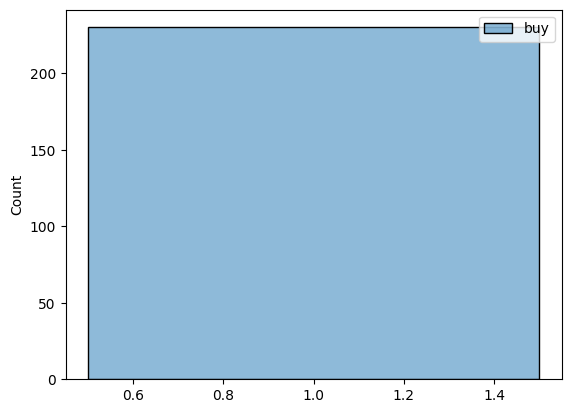

In [22]:
buy_sell = results_df.Y > 0
seaborn.histplot(pd.DataFrame({'buy': buy_sell}))